In [1]:
import os 
import zipfile
import pandas as pd 
import matplotlib.pyplot as plt

zip_data_path_list = [os.path.join('../input/instacart-market-basket-analysis',data_zip)  for data_zip in os.listdir('../input/instacart-market-basket-analysis')]
zip_data_path_list

# mkdir data
if not os.path.isdir('../working/data'):
    os.mkdir('../working/data')
    
# # mkdir output
# if not os.path.isdir('../working/output'):
#     os.mkdir('../working/output')
    

# unzip it to csv 
for zip_data_path in zip_data_path_list:
    with zipfile.ZipFile(zip_data_path,'r') as  zip_ref:
        zip_ref.extractall('../working/data/')

In [2]:
order_prior = pd.read_csv('../working/data/order_products__prior.csv')
order_train = pd.read_csv('../working/data/order_products__train.csv')
orders = pd.read_csv('../working/data/orders.csv')
dept = pd.read_csv('../working/data/departments.csv')
products = pd.read_csv('../working/data/products.csv')
aisels = pd.read_csv('../working/data/aisles.csv')


Processing Products...
Done

Processing Users
Done

Processing Database...
Done

Processing training and testing data
Done

Modeling...
[02:41:49] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Done

Predicting...
Done

Creating Submission
Done


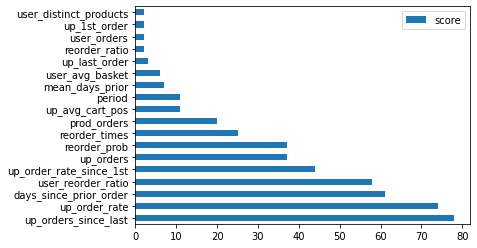

In [3]:
# 0.37510
import pandas as pd
from xgboost import XGBClassifier
order_prior = pd.read_csv('../working/data/order_products__prior.csv')
order_train = pd.read_csv('../working/data/order_products__train.csv')
orders = pd.read_csv('../working/data/orders.csv')
dept = pd.read_csv('../working/data/departments.csv')
products = pd.read_csv('../working/data/products.csv')
aisels = pd.read_csv('../working/data/aisles.csv')


#region < Data Preprocessing: Products >
# merge products, aisels, department
print('Processing Products...')
products = pd.merge(products, aisels, on='aisle_id', how='right')
products = pd.merge(products, dept, on='department_id', how='right')
del aisels, dept

# add user_id column to order_train
order_train = pd.merge(order_train, orders[['order_id', 'user_id']], on='order_id', how='right')

# merge orders, order_prior
orders_products = pd.merge(orders, order_prior, on='order_id', how='inner')
del order_prior

# create prd 
gp = orders_products.groupby('product_id')
prd = pd.DataFrame(gp.size(), columns=['prod_orders'])
prd['prod_reorder'] = gp['reordered'].agg('sum')
prd.reset_index()

tmp = orders_products.copy()
gp = orders_products.groupby(['user_id', 'product_id'])
tmp['prod_order'] = gp.cumcount()
prd['prod_1st_orders'] = tmp[tmp['prod_order']==0].groupby('product_id')['prod_order'].count()
prd['prod_2nd_orders'] = tmp[tmp['prod_order']==1].groupby('product_id')['prod_order'].count()
del tmp

prd['reorder_prob'] = prd.prod_2nd_orders/prd.prod_1st_orders
prd['reorder_times'] = [i+1 for i in prd.prod_reorder/prd.prod_1st_orders]
prd['reorder_ratio'] = prd.prod_reorder/prd.prod_orders
prd = prd.drop(['prod_reorder', 'prod_1st_orders', 'prod_2nd_orders'], axis=1)
del products
print('Done')
print()
#endregion


#region < Data Preprocessing: Users >
print('Processing Users')
prior = orders[orders['eval_set'] == 'prior']
gp = prior.groupby('user_id')
users = pd.DataFrame(gp.size(), columns=['user_orders'])
users['period'] = gp['days_since_prior_order'].agg('sum')
users['mean_days_prior'] = gp['days_since_prior_order'].agg('mean')
users = users.reset_index()
del prior


gp = orders_products.groupby('user_id')
us = pd.DataFrame(gp.size(), columns=['user_total_products'])
order_number_count = gp['order_number'].agg(lambda x: sum(x>1))
reorder_count = gp['reordered'].agg('sum')
us['user_reorder_ratio'] = reorder_count/order_number_count
del order_number_count, reorder_count
us['user_distinct_products'] = gp['product_id'].nunique()
us = us.reset_index()

users = pd.merge(users, us, on='user_id', how='inner')
users['user_avg_basket'] = users['user_total_products']/users['user_orders']

us = orders.loc[orders['eval_set'] != 'prior', ['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
users = pd.merge(users, us, on='user_id', how='inner')
del us
print('Done')
print()
#endregion


#region < Data Preprocessing: Database >
print('Processing Database...')
gp = orders_products.groupby(['user_id', 'product_id'])
dt = pd.DataFrame(gp.size(), columns=['up_orders'])
dt['up_1st_order'] = gp['order_number'].agg('min')
dt['up_last_order'] = gp['order_number'].agg('max')
dt['up_avg_cart_pos'] = gp['add_to_cart_order'].agg('mean')
dt = dt.reset_index()
del orders_products, orders

dt = pd.merge(dt, prd, on='product_id', how='inner')
dt = pd.merge(dt, users, on='user_id', how='inner')

dt['up_order_rate'] = dt['up_orders']/dt['user_orders']
dt['up_orders_since_last'] = dt['user_orders'] - dt['up_last_order']
dt['up_order_rate_since_1st'] = dt['up_orders']/(dt['user_orders']-dt['up_1st_order']+1) 


dt = pd.merge(dt, order_train[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')
del order_train, prd, users
print('Done')
print()
#endregion


#region < Training & Testing Data >
print('Processing training and testing data')
train = dt[dt['eval_set']=='train']
train = train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1)
train['reordered'] = train['reordered'].fillna(0)

test = dt[dt['eval_set']=='test']
test = test.drop(['eval_set', 'user_id', 'reordered'], axis=1)

del dt
print('Done')
print()
#endregion

#region < Modeling >
print('Modeling...')
import xgboost as xgb
from xgboost import XGBClassifier
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 2,
    'min_child_weight': 10,
    'gamma': 0.1,
    'subsample': 0.76,
    'colsample_bytree': 0.95,
    'alpha': 0.05,
    'lambda': 10,
    'n_estimators':160
}

subtrain = train.sample(frac=0.1, random_state=2)
X = xgb.DMatrix(subtrain.drop(['reordered'], axis=1), label=subtrain['reordered'])
model = xgb.train(params, X, num_boost_round=160)

importances = model.get_score(importance_type='weight')
importances_keys = list(importances.keys())
importances_vals = list(importances.values())
tmp = pd.DataFrame(data=importances_vals, index=importances_keys, columns=["score"]).sort_values(by = "score", ascending=False)
tmp.plot(kind='barh')
del tmp
print('Done')
print()
#endregion

#region < Applying Model > 
print('Predicting...')
X = xgb.DMatrix(test.drop(['order_id', 'product_id'], axis=1))
test['reordered'] = model.predict(X)
test.loc[test['reordered'] > 0.21, 'reordered'] = 1

print('Done')
print()

# pack up products of each order
print('Creating Submission')
submission = test[test['reordered']==1]
submission = submission.groupby('order_id')['product_id'].agg(lambda l: ' '.join([str(i) for i in l]))
submission = submission.to_frame('products').reset_index()

# fill missing order_id
missing_orders = pd.DataFrame(set(test.order_id) - set(submission.order_id), columns=['order_id'])
missing_orders['products'] = 'None'
submission = submission.append(missing_orders)
submission = submission.sort_values('order_id')
submission.columns = ['order_id', 'products']

submission.to_csv('../working/submossion.csv', index=False)
print('Done')
#endregion

